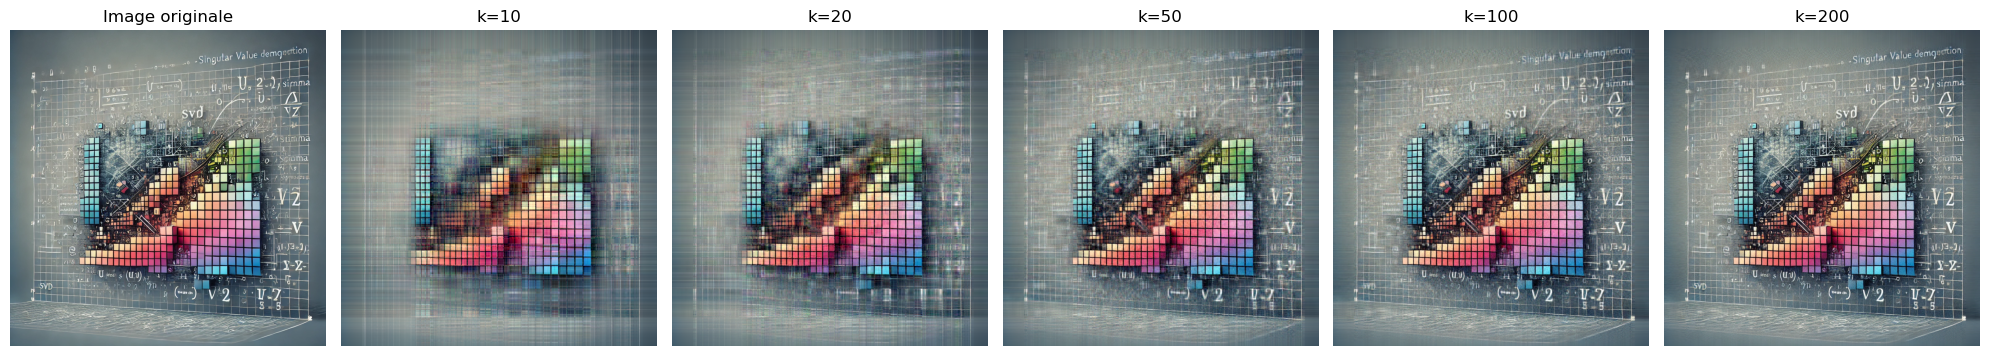

k=10: MSE=0.0128, Ratio de compression=0.0195
k=20: MSE=0.0096, Ratio de compression=0.0391
k=50: MSE=0.0059, Ratio de compression=0.0977
k=100: MSE=0.0034, Ratio de compression=0.1954
k=200: MSE=0.0014, Ratio de compression=0.3908


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

def load_image(image_path):
    """
    Charge une image couleur sans redimensionnement.
    """
    img = io.imread(image_path).astype(np.float32) / 255.0  # Normaliser entre 0 et 1
    return img

def apply_svd(image_channel):
    """
    Applique la SVD sur un canal d'une image (R, G ou B).
    """
    U, S, Vt = np.linalg.svd(image_channel, full_matrices=False)
    Σ = np.diag(S)  # Construire Σ comme une matrice diagonale
    return U, Σ, Vt, S

def reconstruct_image(U, Σ, Vt, k):
    """
    Reconstruit une image à partir des k premières valeurs singulières.
    """
    S_k = np.zeros_like(Σ)
    np.fill_diagonal(S_k, np.diag(Σ)[:k])  # Conserver seulement les k premières valeurs singulières
    U_k = U[:, :k]
    Vt_k = Vt[:k, :]
    return np.dot(U_k, np.dot(S_k[:k, :k], Vt_k))

def calculate_mse(original, reconstructed):
    """
    Calcule l'erreur quadratique moyenne (MSE) entre deux images.
    """
    return np.mean((original - reconstructed) ** 2)

def compression_ratio(original_shape, k):
    """
    Calcule le ratio de compression.
    """
    m, n, _ = original_shape
    return (3 * (m * k + k + n * k)) / (3 * m * n)  # 3 canaux (R, G, B)

if __name__ == "__main__":
    # Chemin vers l'image d'origine
    image_path = "imageoriginal.png"  # Remplacez par le chemin de votre image
    image = load_image(image_path)  # Charger l'image sans redimensionnement
    
    # Appliquer la SVD sur les canaux R, G, et B
    U_R, Σ_R, Vt_R, S_R = apply_svd(image[:, :, 0])
    U_G, Σ_G, Vt_G, S_G = apply_svd(image[:, :, 1])
    U_B, Σ_B, Vt_B, S_B = apply_svd(image[:, :, 2])
    
    # Réduction de rang et reconstruction des canaux pour k=10, 20, 50, 100, 200
    ks = [10, 20, 50, 100, 200]
    reconstructed_images = []
    
    for k in ks:
        R_reconstructed = reconstruct_image(U_R, Σ_R, Vt_R, k)
        G_reconstructed = reconstruct_image(U_G, Σ_G, Vt_G, k)
        B_reconstructed = reconstruct_image(U_B, Σ_B, Vt_B, k)
        
        # Combiner les canaux reconstruits
        reconstructed_image = np.stack([R_reconstructed, G_reconstructed, B_reconstructed], axis=2)
        reconstructed_image = np.clip(reconstructed_image, 0, 1)  # Limiter les valeurs entre 0 et 1
        reconstructed_images.append(reconstructed_image)
    
    # Afficher les images originales et reconstruites
    fig, axes = plt.subplots(1, len(ks) + 1, figsize=(20, 5))
    axes[0].imshow(image)
    axes[0].set_title("Image originale")
    axes[0].axis('off')

    for i, k in enumerate(ks):
        axes[i + 1].imshow(reconstructed_images[i])
        axes[i + 1].set_title(f"k={k}")
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

    # Analyse pour chaque valeur de k
    for i, k in enumerate(ks):
        mse = calculate_mse(image, reconstructed_images[i])
        ratio = compression_ratio(image.shape, k)
        print(f"k={k}: MSE={mse:.4f}, Ratio de compression={ratio:.4f}")
